# Document AI Hands On for Partners

## Overview


이번 실습에서는 upstage에서 개발한 Document AI 제품의 OCR, KIE 두 모델을 소개합니다.  
이 노트북 파일에서는 해당 모델들의 기본 설정 방법, 핵심 구성 요소에 대한 이해, 그리고 각종 예제를 실행하여 기본적인 기능을 시연할 것 입니다.

## 실습의 목적
이 실습의 목적은 사용자들이 Upstage Document AI API에 익숙해지도록 돕는 것 입니다.  
이 튜토리얼이 끝나면, 사용자는 API 호출을 통해 Document AI 제품군을 실행하는 기본적인 방법을 이해하게 되며, 이후 2Q 실습에서 진행될 더 복잡한 작업과 응용을 수행할 수 있는 준비가 될 것입니다.  
이 1Q 예제는 다양한 상황에서의 OCR, KIE 제품 기능을 활용하기 위한 기초를 제공합니다.

## 0. 환경 설정

시작에 앞서 제공되는 실습을 위한 각종 환경 설정을 진행합니다. 순서는 다음과 같습니다.

- 0.1 VS Code 및 Python 설치하기 (Colab 환경은 제외)
- 0.2 폴더 구조 및 이미지 준비
- 0.3 각종 라이브러리 설치하기
- 0.4 API key 복사하기


### 0.1 VS Cdoe 및 Python 설치하기

### 0.2 폴더 구조 및 이미지 준비

In [ ]:
import os

def print_tree(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # root_dir를 기준으로 몇 단계 아래에 있는지 계산
        level = dirpath.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}📁 {os.path.basename(dirpath)}/")
        for f in filenames:
            print(f"{indent}    📄 {f}")

# 원하는 폴더 경로로 수정
root_directory = r"..\HandsOn"
print_tree(root_directory)

### 0.3 각종 라이브러리 설치하기

In [9]:
# API 사용을 위해 필요
!pip install requests

In [10]:
# 파일구조 표현을 위해 필요
!pip install rich

In [54]:
!pip install exifread


   ---------------------------------------- 0.0/40.4 kB ? eta -:--:--
   ---------- ----------------------------- 10.2/40.4 kB ? eta -:--:--
   ------------------------------ --------- 30.7/40.4 kB 445.2 kB/s eta 0:00:01
   ---------------------------------------- 40.4/40.4 kB 486.9 kB/s eta 0:00:00


### 0.4 API Key 복사하기

https://www.upstage.ai/

In [ ]:
api_key = "up_DbdHtFqI0HohXfJXzg7yhbxgsRzJq" # env 파일로 변경

In [ ]:
# @title set API key
from pprint import pprint
import os

import warnings

warnings.filterwarnings("ignore")

if "google.colab" in str(get_ipython()):
    # Running in Google Colab. Please set the UPSTAGE_API_KEY in the Colab Secrets
    from google.colab import userdata

    os.environ["UPSTAGE_API_KEY"] = userdata.get("UPSTAGE_API_KEY")
else:
    # Running locally. Please set the UPSTAGE_API_KEY in the .env file
    from dotenv import load_dotenv

    load_dotenv()

assert (
    "UPSTAGE_API_KEY" in os.environ
), "Please set the UPSTAGE_API_KEY environment variable"

---

## 1.  OCR API 사용하기
- 1.1 기본 API 호출 하기
- 1.2 기본 Output 구조 익히기
- 1.3 bbox 그리기 및 출력 순서 확인하기
- 1.4 Rotated, Watermarks, Noise, Checkboxes
- 1.5 DPI
- 1.6 Multi-pages

### 1.1 기본 API 호출 하기

In [101]:
import os
import requests
import json
import time

SUPPORTED_EXTENSIONS = (
    '.jpg', '.jpeg',  # JPEG
    '.png',           # PNG
    '.bmp',           # BMP
    '.tif', '.tiff',  # TIFF
    '.pdf',           # PDF
    '.heic',          # HEIC
    '.docx',          # DOCX
    '.pptx',          # PPTX
    '.xlsx'           # XLSX
)

def save_ocr_result_with_retry(
    file_path,
    url,
    headers,
    output_file_path,
    max_retries=5,
    base_sleep_time=10
):
    """
    단일 파일에 대해 OCR API 호출 -> 결과 JSON 저장 과정을 수행하는 함수.
    429(too_many_requests) 에러가 발생하면
    일정 시간 대기 후 재시도합니다.
    
    Parameters
    ----------
    file_path : str
        OCR을 진행할 이미지 파일 경로
    url : str
        OCR API 엔드포인트 URL
    headers : dict
        OCR API에 필요한 헤더 정보 (e.g. {"Authorization": "Bearer ..."})
    output_file_path : str
        OCR 결과를 저장할 JSON 파일 경로
    max_retries : int, optional
        429 에러 발생 시 재시도할 최대 횟수
    base_sleep_time : int, optional
        재시도 시도 간 기본 대기 시간(초). 매 재시도 시 배수로 증가 가능.
    """
    # 재시도 횟수
    retry_count = 0
    
    while True:
        with open(file_path, "rb") as file:
            files = {"document": file}
            response = requests.post(url, headers=headers, files=files)

        # 응답 상태코드 확인
        if response.status_code == 429:  # Too Many Requests
            retry_count += 1
            if retry_count > max_retries:
                # print(f"[ERROR] 재시도 횟수 초과 (파일: {file_path})")
                return  # 혹은 raise Exception 등을 통해 에러 처리
            
            # 응답에 지정된 대기 시간이 있으면 쓰는 게 가장 좋음(예: response.headers["Retry-After"])
            # 없으면 base_sleep_time의 배수만큼 대기
            wait_time = base_sleep_time * retry_count
            # print(f"[WARNING] 429 Too Many Requests. {wait_time}초 후 재시도합니다. (재시도 {retry_count}/{max_retries})")
            time.sleep(wait_time)
            continue
        else:
            # JSON 파싱
            try:
                ocr_data = response.json()
            except json.JSONDecodeError:
                print(f"[ERROR] JSON 디코딩 실패 (파일: {file_path})")
                return
            
            # OCR API에서 에러 메시지가 왔는지 확인
            error_info = ocr_data.get("error", {})
            error_type = error_info.get("type", "")
            error_code = error_info.get("code", "")
            
            if error_type == "too_many_requests" or error_code == "too_many_requests":
                # 이 경우도 429와 동일하게 처리(대기 후 재시도)
                retry_count += 1
                if retry_count > max_retries:
                    # print(f"[ERROR] 재시도 횟수 초과 (파일: {file_path})")
                    return
                wait_time = base_sleep_time * retry_count
                # print(f"[WARNING] too_many_requests 에러. {wait_time}초 후 재시도합니다. (재시도 {retry_count}/{max_retries})")
                time.sleep(wait_time)
                continue
            else:
                # 정상 응답(혹은 다른 에러지만 429는 아님)이면 JSON 저장
                with open(output_file_path, "w", encoding="utf-8") as f:
                    json.dump(ocr_data, f, ensure_ascii=False, indent=4)
                # print("[INFO] OCR 결과 저장 완료:", output_file_path)
                return


def process_ocr_in_folder(root_ocr_img, root_ocr_json, url, headers, max_retries=5, base_sleep_time=10):
    """
    지정된 폴더 내 이미지 파일에 대하여 OCR을 진행하고,
    결과를 JSON으로 저장하는 함수입니다.
    429 에러가 발생할 경우 일정 시간 대기 후 재시도합니다.

    Parameters
    ----------
    root_ocr_img : str
        OCR 대상 이미지가 있는 폴더 경로
    root_ocr_json : str
        OCR 결과 JSON을 저장할 폴더 경로
    url : str
        OCR API 엔드포인트 URL
    headers : dict
        OCR API에 필요한 헤더 정보
    max_retries : int, optional
        429 에러 발생 시 재시도할 최대 횟수
    base_sleep_time : int, optional
        재시도 시도 간 기본 대기 시간(초). 매 재시도 시 배수로 증가 가능.
    """
    # 폴더 내 파일 순회
    for filename in os.listdir(root_ocr_img):
        # 이미지인지 확인
        if filename.lower().endswith(SUPPORTED_EXTENSIONS):
            file_path = os.path.join(root_ocr_img, filename)
            base_name = os.path.splitext(filename)[0]
            output_file_path = os.path.join(root_ocr_json, f"{base_name}.json")

            # print(f"[INFO] Processing: {file_path}")
            
            # OCR 결과 저장 (429 대응 재시도 포함)
            save_ocr_result_with_retry(
                file_path=file_path,
                url=url,
                headers=headers,
                output_file_path=output_file_path,
                max_retries=max_retries,
                base_sleep_time=base_sleep_time
            )
    print("End")

In [102]:
root_ocr_img = r"images\ocr"
root_ocr_json = r"results\ocr"

url = "https://api.upstage.ai/v1/document-ai/ocr"
headers = {"Authorization": f"Bearer {api_key}"}

process_ocr_in_folder(
    root_ocr_img=root_ocr_img,
    root_ocr_json=root_ocr_json,
    url=url,
    headers=headers,
    max_retries=5,        # 재시도 최대 5회
    base_sleep_time=10    # 기본 대기 시간 10초 (재시도 시 2배씩 증가)
)

End

### 1.2 기본 Output 구조 익히기

In [93]:
from rich.tree import Tree
from rich import print
import json

def get_structure_fingerprint(data):
    """
    재귀적으로 딕셔너리(또는 리스트)의 key 구조에 대한 고유한 튜플 형태의 지문을 생성합니다.
    """
    if isinstance(data, dict):
        items = []
        for key, value in data.items():
            if isinstance(value, (dict, list)):
                sub_fp = get_structure_fingerprint(value)
                items.append((key, sub_fp))
            else:
                items.append((key, None))
        # key 순서를 정렬하여 일관된 튜플을 생성합니다.
        return ("dict", tuple(sorted(items)))
    elif isinstance(data, list):
        if data:
            # 리스트의 첫 요소를 대표 구조로 사용
            return ("list", get_structure_fingerprint(data[0]))
        else:
            return ("list", None)
    else:
        return ("value", type(data).__name__)

def build_key_tree(data, tree, seen_fps):
    """
    data 내의 딕셔너리 key 구조를 rich의 Tree 객체에 추가합니다.
    이미 본 구조(fingerprint)는 중복 출력하지 않고 (repeated)로 표시합니다.
    """
    if isinstance(data, dict):
        # 현재 딕셔너리의 구조 지문 계산
        fp = get_structure_fingerprint(data)
        if fp in seen_fps:
            tree.add("[red](repeated)[/red]")
            return
        seen_fps.add(fp)
        for key, value in data.items():
            branch = tree.add(str(key))
            if isinstance(value, (dict, list)):
                build_key_tree(value, branch, seen_fps)
    elif isinstance(data, list):
        # 리스트의 경우 첫 요소만 대표 구조로 처리 (동일 구조가 반복될 가능성이 높으므로)
        if data and isinstance(data[0], (dict, list)):
            build_key_tree(data[0], tree, seen_fps)

# JSON 파일 읽기 (파일 경로를 환경에 맞게 조정)
with open(r"results\ocr\reciepts.json", "r", encoding="utf-8") as f:
    ocr_data = json.load(f)


In [94]:
# rich Tree 객체 생성
tree = Tree("JSON")
build_key_tree(ocr_data, tree, set())
print(tree)

JSON
├── apiVersion
├── confidence
├── metadata
│   └── pages
│       ├── height
│       ├── page
│       └── width
├── mimeType
├── modelVersion
├── numBilledPages
├── pages
│   ├── confidence
│   ├── height
│   ├── id
│   ├── text
│   ├── width
│   └── words
│       ├── boundingBox
│       │   └── vertices
│       │       ├── x
│       │       └── y
│       ├── confidence
│       ├── id
│       └── text
├── stored
└── text

### 1.3 bbox 그리기 및 출력 순서 확인하기

In [95]:
import os
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

def plot_ocr_boxes(json_path, img_path, max_boxes=20, figsize=(12, 9)):
    """
    주어진 OCR 결과 JSON 파일(json_path)과 이미지(img_path)를 기반으로,
    OCR 바운딩 박스를 최대 max_boxes개까지 이미지 위에 그려서 보여주는 함수입니다.
    
    Parameters
    ----------
    json_path : str
        OCR 결과 JSON 파일 경로
    img_path : str
        원본 이미지 파일 경로
    max_boxes : int, optional
        표시할 바운딩 박스의 최대 개수 (기본값: 20)
    figsize : tuple, optional
        plt.subplots에 지정할 figure 크기 (기본값: (12, 9))
    """
    # JSON 파일 로드
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 이미지 로드
    img = plt.imread(img_path)

    # 첫 번째 페이지의 words 정보 가져오기
    page = data["pages"][0]
    words = page["words"]

    # 실제 표시할 바운딩 박스 개수 결정
    n_boxes = min(max_boxes, len(words))

    # 바운딩 박스 정보 (4점 좌표와 중점) 추출
    boxes = []
    for i in range(n_boxes):
        word = words[i]
        vertices = word["boundingBox"]["vertices"]
        # (x, y) 좌표 튜플로 변환
        points = [(v.get("x", 0), v.get("y", 0)) for v in vertices]
        # 네 점의 중점
        center = (sum(p[0] for p in points) / len(points),
                  sum(p[1] for p in points) / len(points))
        boxes.append({
            "points": points,
            "center": center
        })

    # 바운딩 박스를 y좌표(최소값) -> x좌표(최소값) 순으로 정렬
    boxes_sorted = sorted(
        boxes,
        key=lambda b: (min(p[1] for p in b["points"]), min(p[0] for p in b["points"]))
    )

    # 이미지 위에 바운딩 박스 표시
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)

    # 20가지 색상을 위한 컬러맵
    cmap = plt.get_cmap("tab20")

    # 정렬된 순서대로 바운딩 박스 표시
    for idx, box in enumerate(boxes_sorted):
        color = cmap(idx % 20)
        # 폴리곤(패치) 그리기
        poly = Polygon(box["points"], closed=True, edgecolor=color, facecolor='none', linewidth=1)
        ax.add_patch(poly)
        # 중점 표시
        ax.plot(box["center"][0], box["center"][1], marker='o', color=color, markersize=1)
        # 번호 텍스트 표시
        min_x = min(p[0] for p in box["points"])
        min_y = min(p[1] for p in box["points"])
        ax.text(min_x, min_y - 5, str(idx), fontsize=10, color=color, weight='bold')

    plt.axis("off")
    plt.show()


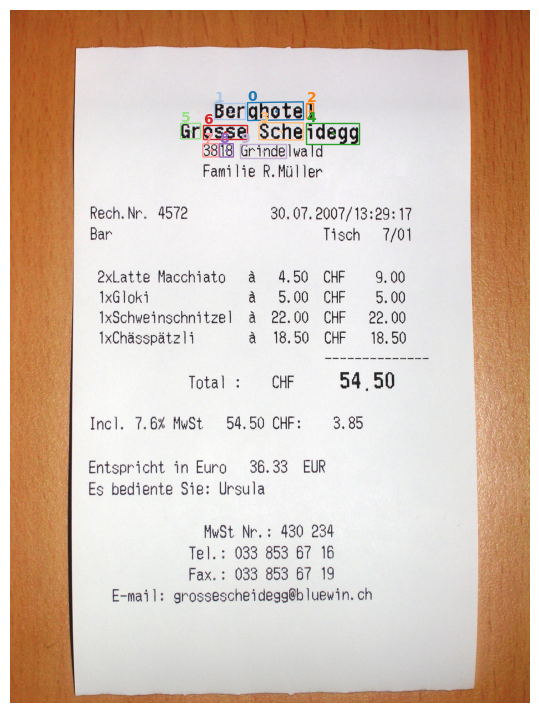

In [97]:
# OCR 결과 JSON 파일 경로
json_path = os.path.join(root_ocr_json, "reciepts.json")
# 원본 이미지 파일 경로
img_path = os.path.join(root_ocr_img, "reciepts.jpg")

plot_ocr_boxes(json_path, img_path, max_boxes=10, figsize=(12, 9))

### 1.4 Rotated, Watermarks, Noise, Checkboxes

In [ ]:
- Rotated 지원 범위
- Watermarks 지원 범위
- Noise 지원 범위
- Checkboxes 지원 범위


---> 루이스한테 확인 후 추가 작업 진행

### DPI

![원하는 이미지 이름](\images\ocr\dpi_75.jpg)

![원하는 이미지 이름](\images\ocr\dpi_table.jpg)

### 1.6 Multi-pages